In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 10 #'full'


In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()

encoder.add(tf.keras.layers.InputLayer(input_shape=dims))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.1))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.3))

# Converting 3D feature to 1D feature Vektor
encoder.add(tf.keras.layers.Flatten())

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.5))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=256))
# Normalization
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(tf.keras.layers.Dense(units=64, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [23]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [24]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


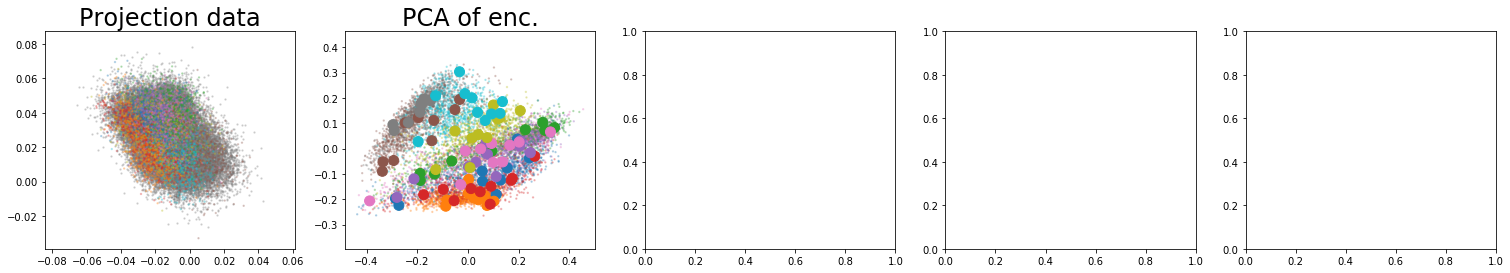

In [25]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [26]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

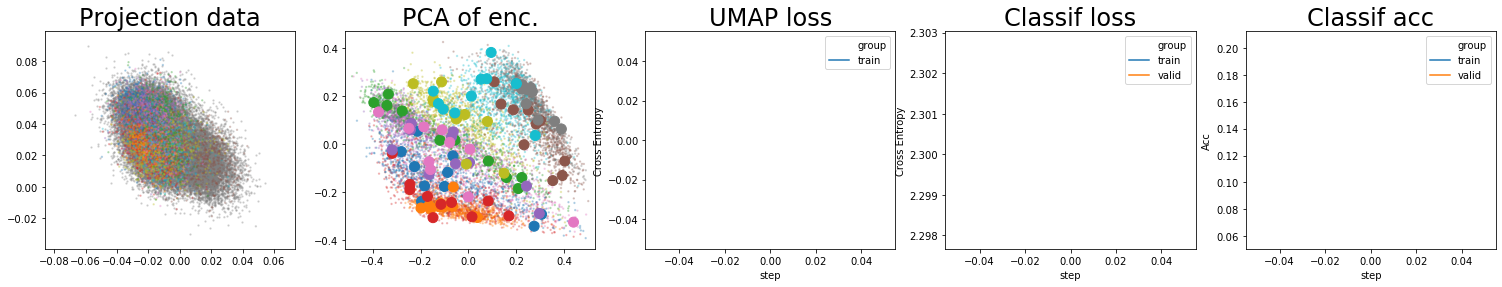

train acc: 0.058 | val acc: 0.205


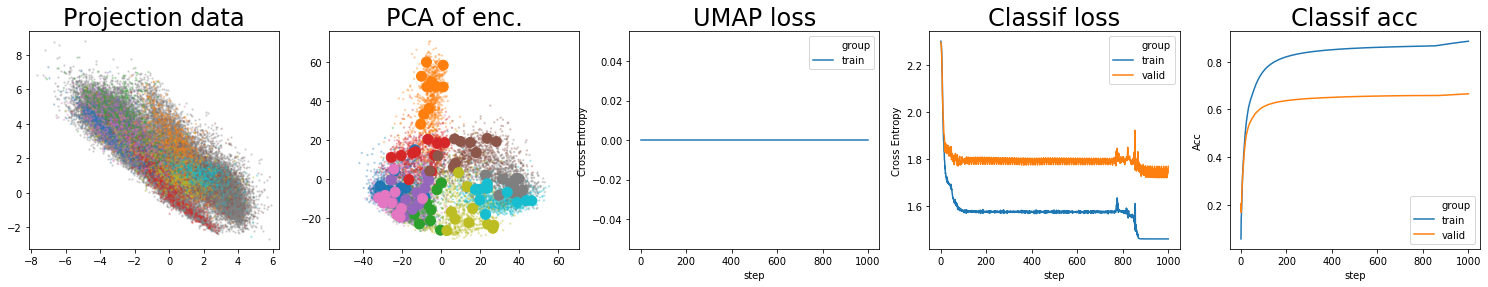

train acc: 0.8856 | val acc: 0.6655


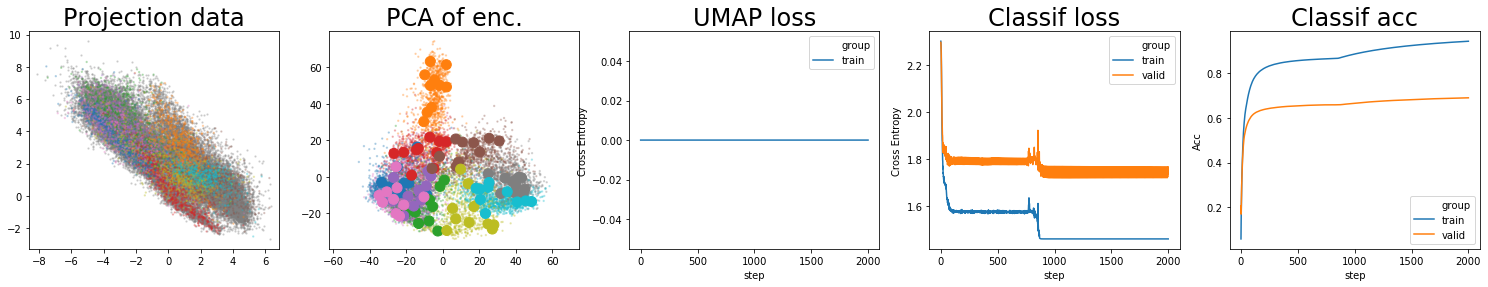

train acc: 0.9428 | val acc: 0.6896


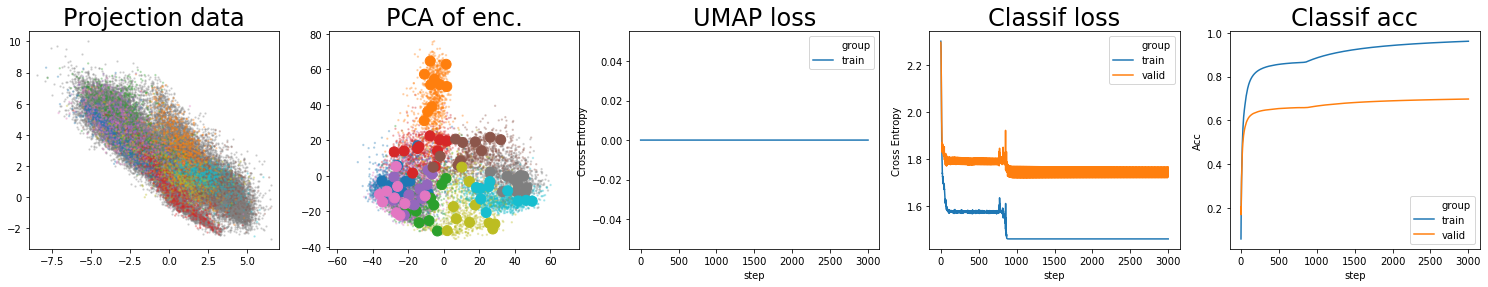

train acc: 0.9619 | val acc: 0.6976


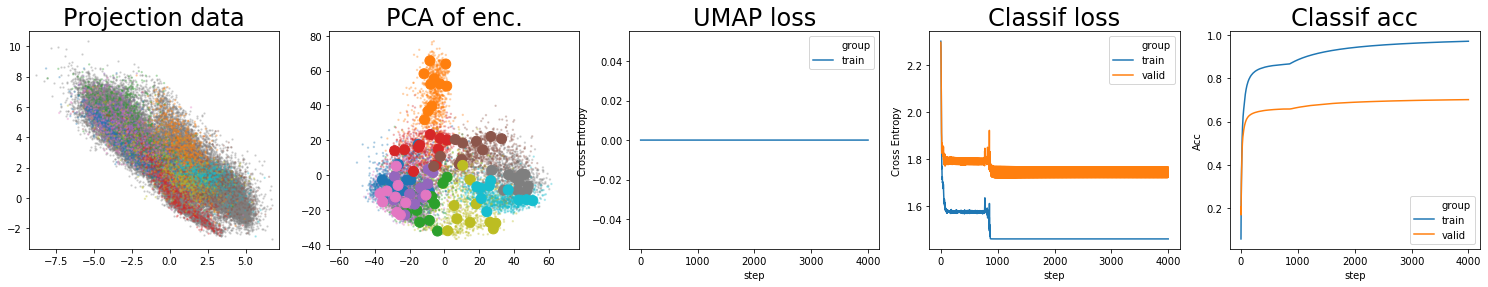

train acc: 0.9714 | val acc: 0.7016


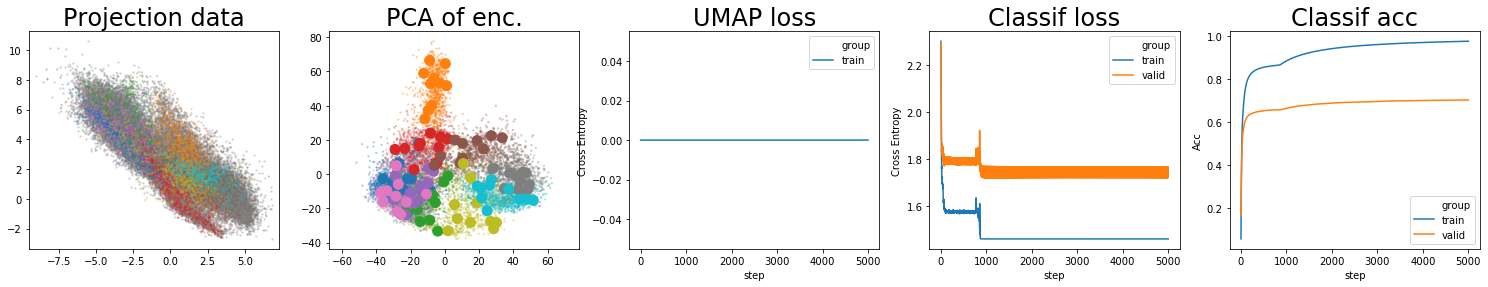

train acc: 0.9771 | val acc: 0.7039


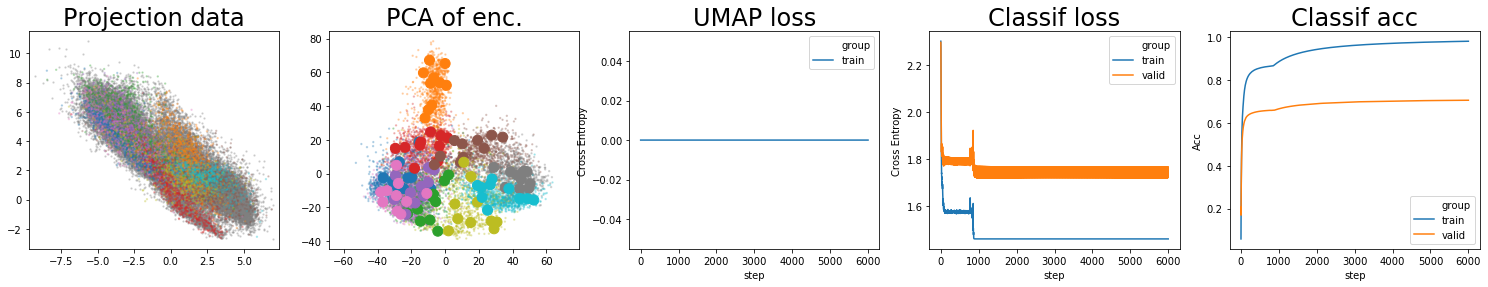

train acc: 0.9809 | val acc: 0.7055


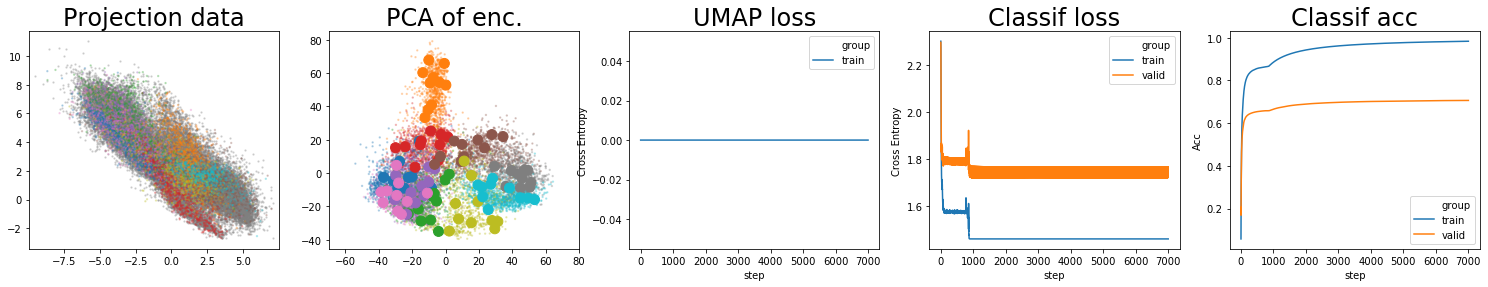

train acc: 0.9836 | val acc: 0.7065


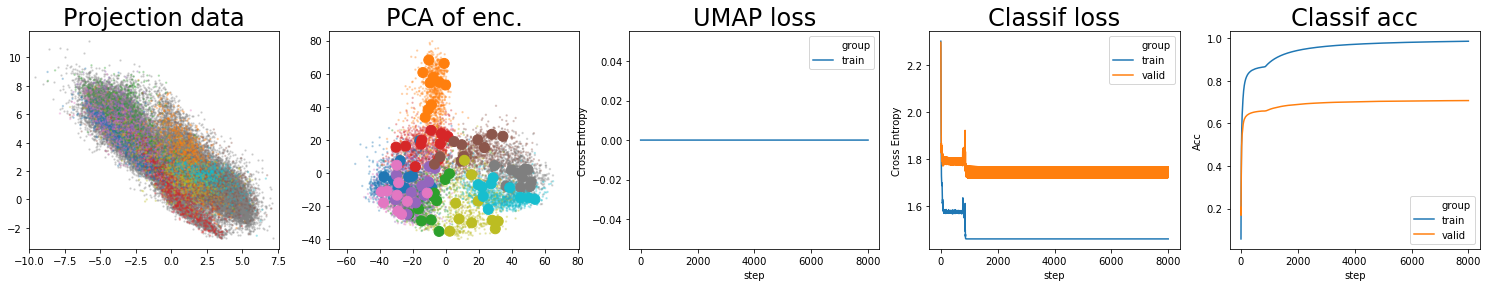

train acc: 0.9857 | val acc: 0.7073


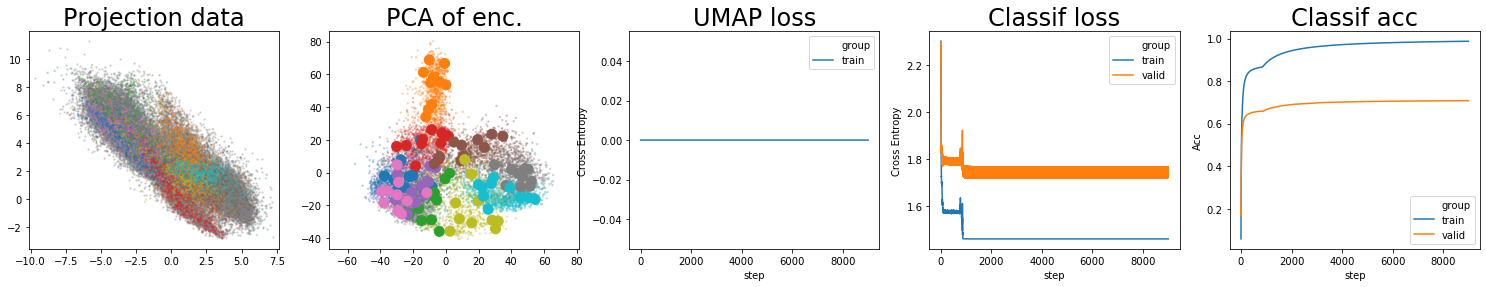

train acc: 0.9873 | val acc: 0.7078


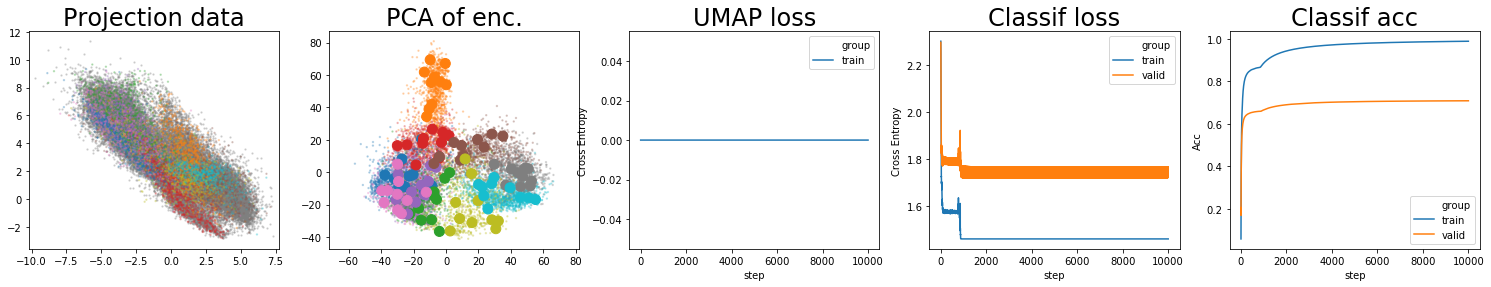

train acc: 0.9886 | val acc: 0.7083


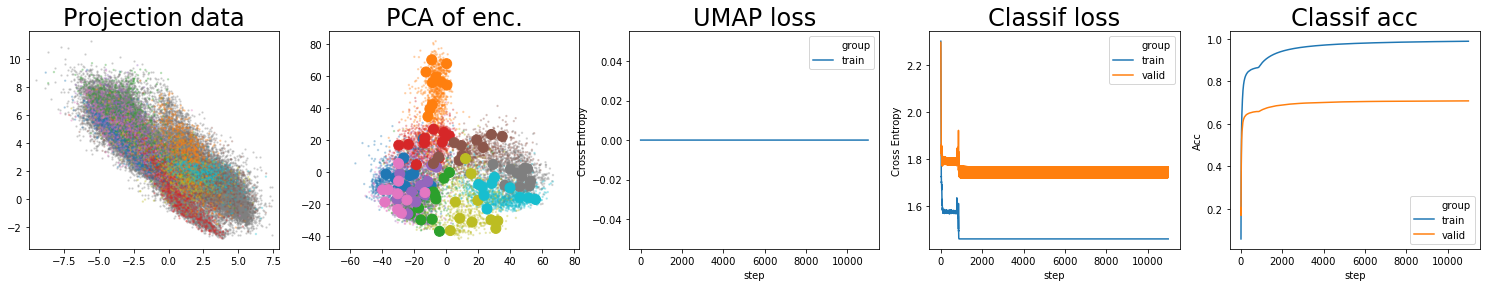

train acc: 0.9896 | val acc: 0.7085


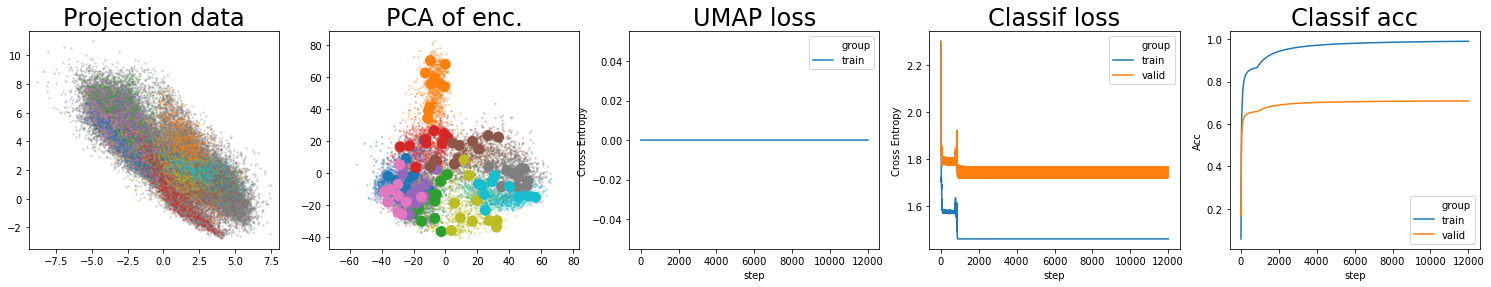

train acc: 0.9905 | val acc: 0.7087


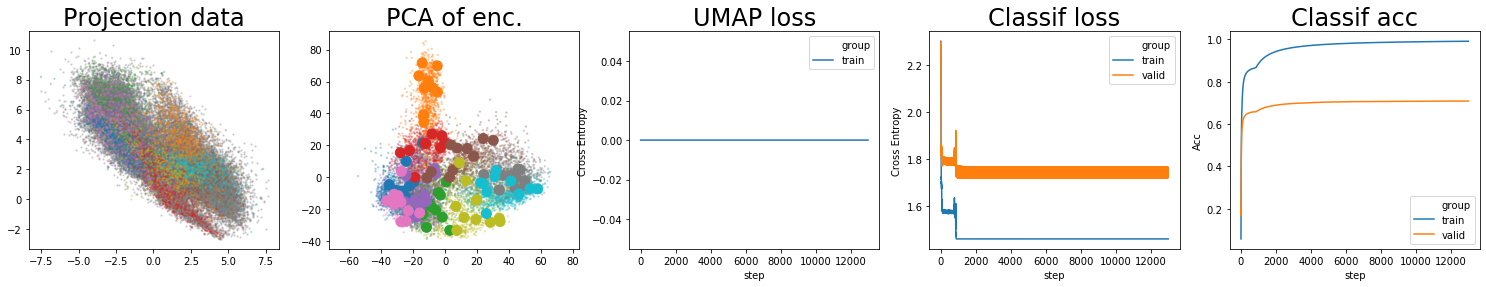

train acc: 0.9912 | val acc: 0.7089


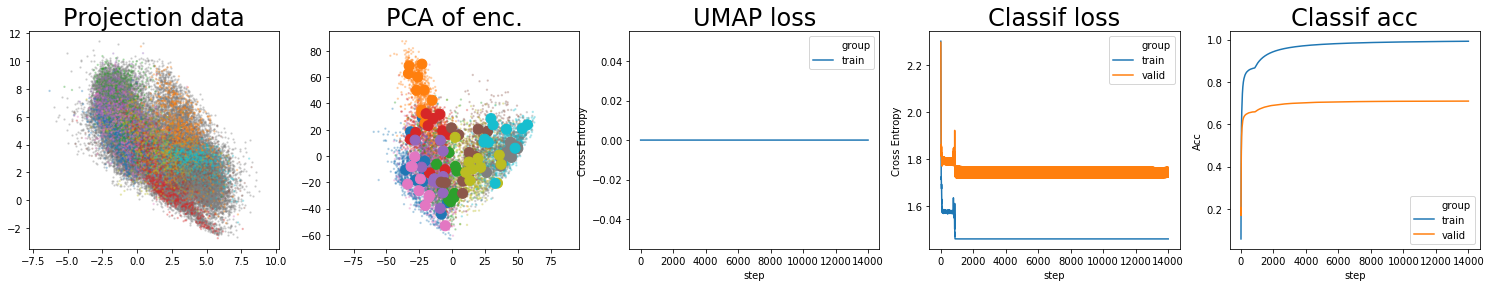

train acc: 0.9918 | val acc: 0.7091


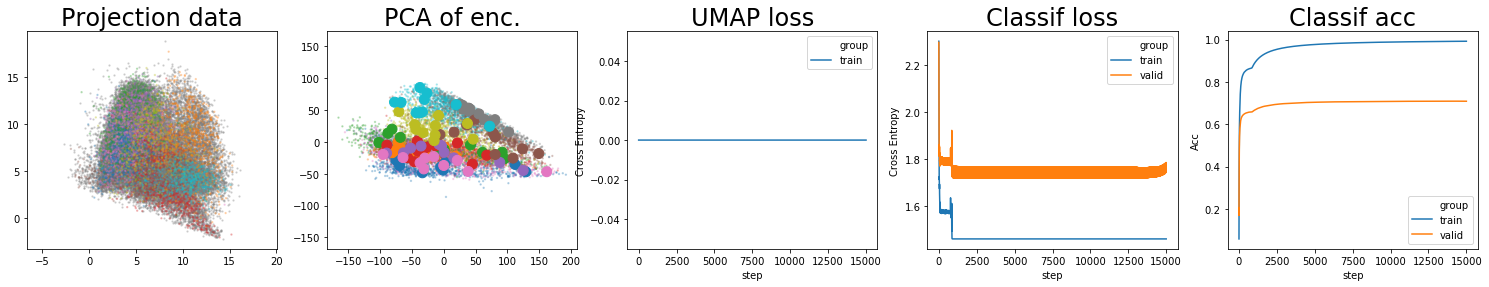

train acc: 0.9924 | val acc: 0.7088


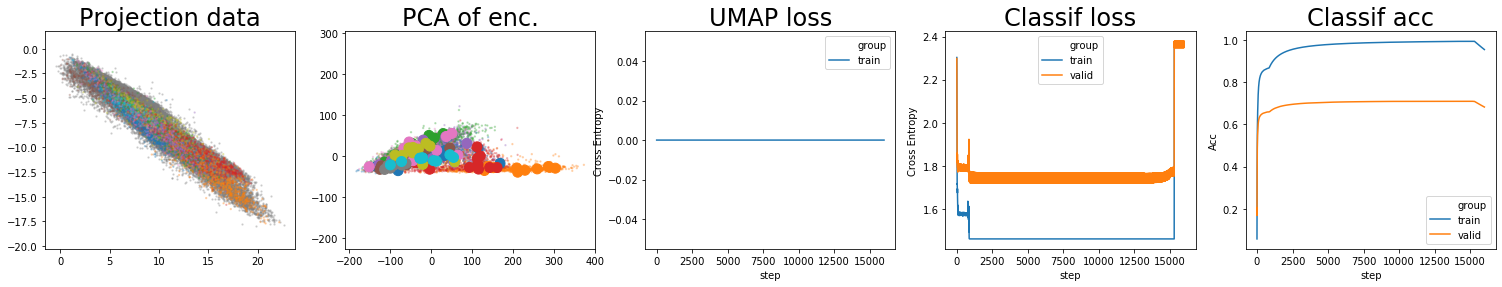

train acc: 0.9532 | val acc: 0.6815


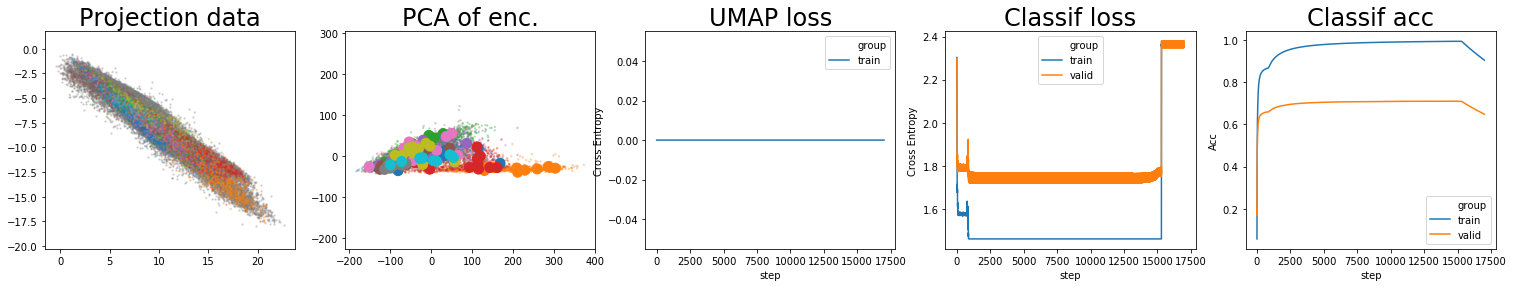

train acc: 0.9031 | val acc: 0.6473


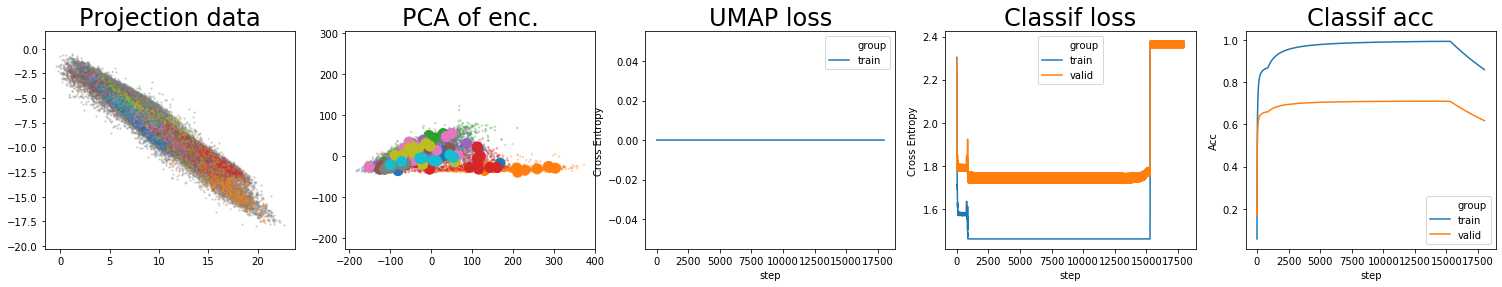

train acc: 0.8584 | val acc: 0.6168


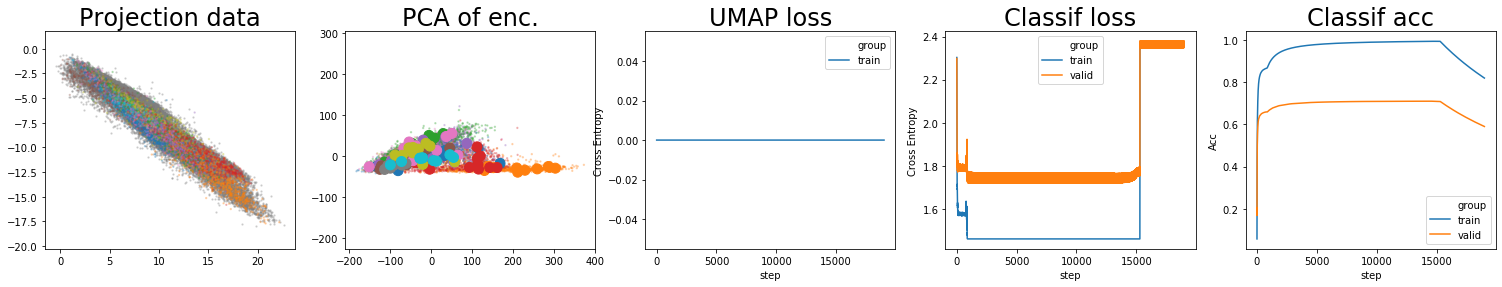

train acc: 0.8185 | val acc: 0.5895


KeyboardInterrupt: 

In [27]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )

        if batch % 1000 == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print("train acc: {} | val acc: {}".format(str(round(classifier_acc.numpy(),4)), str(round(val_acc.numpy(),4))))
        batch += 1

In [ ]:
classifier_acc, classifier_loss

In [ ]:
val_acc, val_loss